# Qiskit Machine Learning v0.5 Migration Guide

This tutorial will guide you through the process of migrating your code from Qiskit Machine Learning v0.4 to v0.5.

## Introduction

The main focus of the 0.5 release of Qiskit Machine Learning is the migration of the base computational blocks like quantum kernels and quantum neural networks to the primitives introduced in Qiskit as well as extended support of the primitives in the algorithms.

Contents:

- Overview of the primitives
- High level algorithms/primitives
- New quantum kernel
- New quantum neural networks
- Notable deprecation


## Overview of the primitives

The core capability of quantum computers that sets them apart from from classical computers is their ability to generate non-classical probability distributions at their outputs. The native operations that one can do with a probability distribution is to sample from it or to estimate quantities on it. Consequently, these operations of sampling and estimating form the fundamental building blocks of quantum algorithm development. Thus, as it was [announced](https://research.ibm.com/blog/qiskit-runtime-for-useful-quantum-computing), two basic primitives were introduced, Sampler and Estimator, respectively, that implement these two operations:

- Sampler class calculates probabilities or quasi-probabilities of bitstrings from quantum circuits. The base class is [qiskit.primitives.BaseSampler](https://qiskit.org/documentation/stubs/qiskit.primitives.BaseSampler.html).
- Estimator class estimates expectation values of quantum circuits and observables. The base class is [qiskit.primitives.BaseEstimator](https://qiskit.org/documentation/stubs/qiskit.primitives.BaseEstimator.html).

Qiskit Terra provides two implementations:

- The reference implementation that is statevector based. This implementation does require a backend or a simulator, it relies on the classes from the [quantum_info](https://qiskit.org/documentation/apidoc/quantum_info.html) package.
- The backend based primitives. This implementation requires an instance of a backend to be passed to the primitives.

More information on the primitives can be found in the [documentation](https://qiskit.org/documentation/apidoc/primitives.html).


## High level algorithms/primitives

In addition to the core primitives new high level algorithms were also introduced:

- Algorithms to calculate the gradient of a quantum circuit. For each core primitive there's a corresponding base interface that defines quantum circuit gradient. The documentation on gradients is [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.html).
- Algorithms that compute the fidelity or "closeness" of pairs of quantum states. Currently, only one implementation is available that requires a sampler primitive and is based on the compute-uncompute method. The documentation is [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.html).

Both two new algorithms are very similar to the core primitives, they share the same method signatures, so they may be called as high level primitives despite they are not in the primitives package.

## New quantum kernel

The existing implementation consists of a single class [QuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html) that does everything:

- Constructs circuits
- Executes circuits and evaluates overlap between circuits
- Provides training parameters
- Keeps track of the values assigned to the parameters. 

The implementation became sophisticated and inflexible and adding support of the new primitives could be tricky. To address the issues, a new flexible and extendable design of quantum kernels was introduced. The goals of the new design are: 

- Migrate to the primitives and leverage the fidelity algorithm. Now users may plug in their own implementations of fidelity calculations.
- Extract trainability feature to a dedicated class.
- Introduce a base class that can be extended by other kernel implementations.

The new design of quantum kernel is shown on the next diagram.

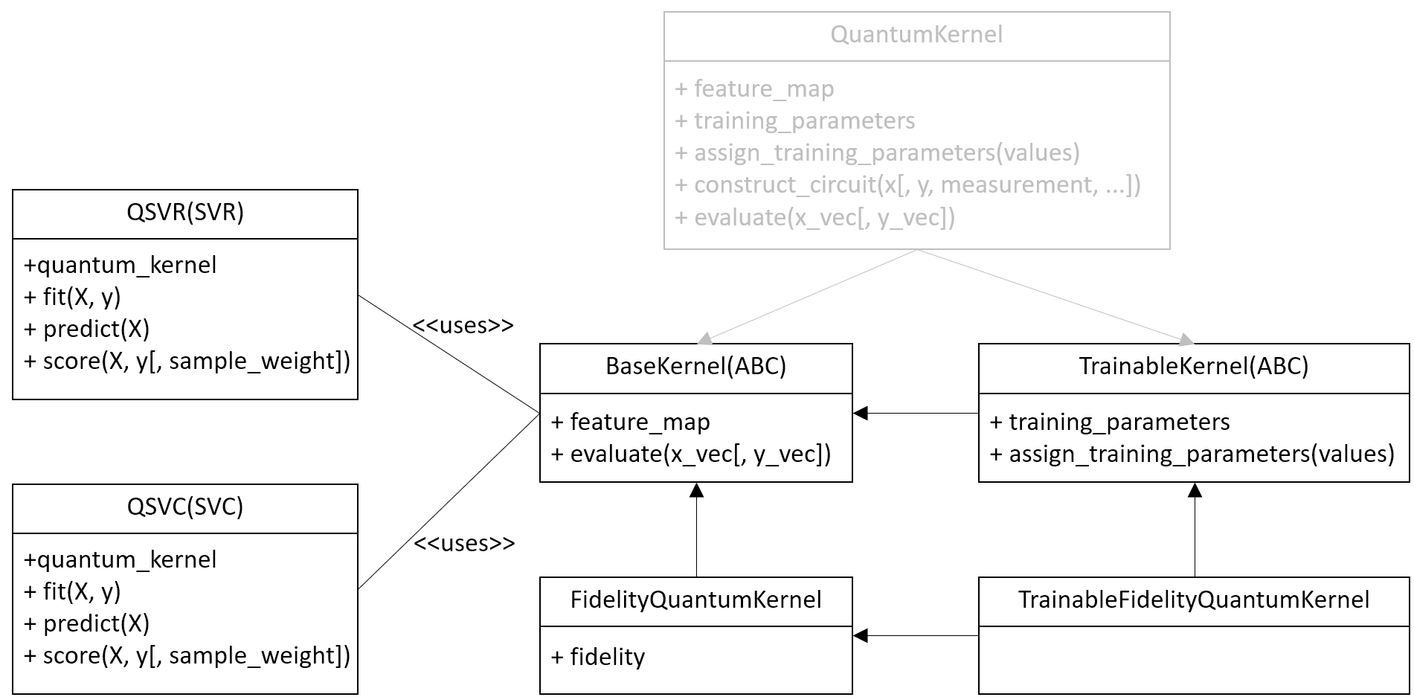

The new kernels expose the same interface and the same parameters except the `quantum_instance` parameter. This parameter does not have a direct replacement and instead the `fidelity` parameter must be used.

A new hierarchy shown on the diagram introduces:

 - A base and abstract class [BaseKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.BaseKernel.html) is introduced. All concrete implementation must inherit this class.
 - A fidelity based quantum kernel [FidelityQuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) is added. This is a direct **replacement** of the existing quantum kernel implementation. The difference is that the new class takes a fidelity instance to estimate overlaps and construct kernel matrix.
 - A new abstract class [TrainableKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.TrainableKernel.html) is introduced to generalize ability to train quantum kernels.
 - A fidelity-based trainable quantum kernel [TrainableFidelityQuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.TrainableFidelityQuantumKernel.html) is introduced. This is a **replacement** of the existing quantum kernel if a trainable kernel is required. The trainer [QuantumKernelTrainer](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.alogrithms.QuantumKernelTrainer.html) now accepts both quantum kernel implementations, the new one and the existing one.
 
For convenience, the existing quantum kernel implementation, [QuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html), now extends both new abstract classes and thus it is compatible with the new introduced interfaces. This implementation is now **pending deprecation**, will be deprecated in a future release and subsequently removed after that. New, primitive-based quantum kernels should be used instead.

The existing algorithms such as [QSVC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html), [QSVR](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVR.html) and other kernel-based algorithms are updated and work with both implementations.

For example a QSVM classifier can be trained as follows.

Generate a simple dataset.

In [1]:
from sklearn.datasets import make_blobs

features, labels = make_blobs(n_samples=20, centers=2, center_box=(-1, 1), cluster_std=0.1)

Fidelity is optional and quantum kernel will create it automatically if none is passed. But here, we create it manually for illustrative purposes.

In [2]:
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

fidelity = ComputeUncompute(sampler=Sampler())

Next, we create a new quantum kernel with the fidelity instance.

In [3]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(2)
kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

And finally we fit an SVM classifier as usual.

In [4]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(features, labels)
qsvc.score(features, labels)

1.0

## New quantum neural networks

Changes in the quantum neural networks are not as dramatic as in quantum kernels. In addition, and as a replacement to the existing neural networks, two new networks are introduced.

### SamplerQNN

A new [Sampler quantum neural network](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html) leverages the sampler primitive and the sampler gradients.

The new [SamplerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html) exposes a similar interface to the existing [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), with a
few differences. One is the `quantum_instance` parameter. This parameter does not have a direct replacement, and instead the `sampler` parameter must be used. The `gradient` parameter keeps the same name as in the [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html) implementation, but it no longer accepts Opflow gradient classes as inputs; instead, this parameter expects an (optionally custom) primitive gradient. The `sampling` option has been removed for the time being, as this information is not currently exposed by the sampler, and might correspond to future lower-level primitives.

The existing training algorithms such as [VQC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) that were based on the [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), are updated to accept both implementations. The implementation of [NeuralNetworkClassifier](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html) has not changed.

The existing [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html) is now **pending deprecation**, superseded by the new [SamplerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html), will be deprecated in a future release and subsequently removed after that.

For example, a [VQC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) model using Sampler can be trained as follows.

Generate a simple dataset.

In [5]:
num_samples = 20
features, labels = make_blobs(n_samples=num_samples, centers=2, center_box=(-1, 1), cluster_std=0.1)

Construct a feature map and an ansatz.

In [6]:
from qiskit.circuit.library import RealAmplitudes

num_inputs = 2
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

Create an instance of the reference Sampler.

In [7]:
sampler = Sampler()

Now, for illustrative purpose we create a instance of the `SamplerQNN`, but we won't be using it as the same instance will be created by `VQC` for us automatically. Once the instance is created you can call `forward` and `backward` as usual. For more information please refer to the [Quantum Neural Networks tutorial](../tutorials/01_neural_networks.ipynb).

In [8]:
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN

circuit = QuantumCircuit(num_inputs)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

qnn = SamplerQNN(
    circuit=circuit, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

Construct a variational quantum classifier and fit it.

In [9]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=30),
)

vqc.fit(features, labels)
vqc.score(features, labels)

1.0

### EstimatorQNN

A new [Estimator quantum neural network](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) leverages the estimator primitive and the estimator gradients.

The new [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) exposes a similar interface to the existing [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html), with a
few differences. One is the `quantum_instance` parameter. This parameter does not have a direct replacement, and instead the `estimator` parameter must be used. The `gradient` parameter keeps the same name as in the [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html) implementation, but it no longer accepts Opflow gradient classes as inputs; instead, this parameter expects an (optionally custom) primitive gradient.

The existing training algorithms such as [VQR](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQR.html) that were based on the [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html), are updated to accept both implementations. The implementation of [NeuralNetworkRegressor](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkRegressor.html) has not changed.

The existing [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html) is now **pending deprecation**, superseded by the new [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html), will be deprecated in a future release and subsequently removed after that.

For example, a [VQR](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQR.html) model using Estimator can be trained as follows.

Generate a simple dataset.

In [10]:
import numpy as np

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
features = (ub - lb) * np.random.rand(num_samples, 1) + lb
labels = np.sin(features[:, 0]) + eps * (2 * np.random.rand(num_samples) - 1)

Construct a feature map and an ansatz.

In [11]:
from qiskit.circuit import Parameter

num_inputs = 1
feature_map = QuantumCircuit(1)
feature_map.ry(Parameter("input"), 0)

ansatz = QuantumCircuit(1)
ansatz.ry(Parameter("weight"), 0)

Create an instance of the reference Estimator.

In [12]:
from qiskit.primitives import Estimator

estimator = Estimator()

Now, for illustrative purpose we create a instance of the `EstimatorQNN`, but we won't be using it as the same instance will be created by `VQR` for us automatically. Once the instance is created you can call `forward` and `backward` as usual. For more information please refer to the [Quantum Neural Networks tutorial](../tutorials/01_neural_networks.ipynb).

In [13]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

circuit = QuantumCircuit(num_inputs)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=circuit, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

Construct a variational quantum regressor and fit it. In this case we use a gradient based optimizer, thus the network makes use of the [default estimator gradient](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.ParamShiftEstimatorGradient.html) that is created automatically.

In [14]:
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import VQR

vqr = VQR(
    feature_map=feature_map, ansatz=ansatz, optimizer=L_BFGS_B(maxiter=5), estimator=Estimator()
)
vqr.fit(features, labels)
vqr.score(features, labels)

0.9653728776651195

## Notable deprecation

A few components are deprecated or pending deprecation with no direct replacements.

- [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html) is pending deprecation. Users should use [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) instead.
- The Distribution Learners package is deprecated fully. This package contains such classes as [DiscriminativeNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.DiscriminativeNetwork.html), [GenerativeNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.GenerativeNetwork.html), [NumPyDiscriminator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NumPyDiscriminator.html), [PyTorchDiscriminator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.PyTorchDiscriminator.html), [QuantumGenerator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QuantumGenerator.html), [QGAN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QGAN.html). Instead, please refer to the [new QGAN tutorial](../tutorials/04_torch_qgan.ipynb). This tutorial introduces step-by-step how to build a PyTorch-based QGAN using quantum neural networks.
- The Runtime package is deprecated. This package contains a client to Qiskit Programs that embed Qiskit Runtime in the algorithmic interfaces and facilitate usage of algorithms and scripts in the cloud. You should use [QiskitRuntimeService](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html) to leverage primitives and runtimes.

In [15]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright